In [1]:
using Random, Distributions
using PyPlot
using Flux

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/alexbird/.julia/packages/PyPlot/4wzW1/src/init.jl:192


In [2]:
using Colors, Formatting
# Define a color midway between <<yellow>> and <<orange>>; these colors picked from Colormaps.
Base.convert(::Type{Array}, x::RGBA) = [x.r, x.g, x.b, x.alpha];
yelloworng = weighted_color_mean(0.6, RGBA(plt.cm.Set2(5)...), RGBA(plt.cm.tab10(1)...))
yelloworng = Tuple(convert(Array, yelloworng))

(1.0, 0.7098039215686274, 0.13254901960784315, 1.0)

In [3]:
function credint(ax, yhat, logsigma; col=cols4[1], alpha=0.2)
    stitchrev(x, y) = vcat(x, reverse(y))
    ax.fill(stitchrev(1:length(yhat), 1:length(yhat)), stitchrev(yhat + logsigma, yhat - logsigma),
    color=col, alpha=alpha)
end

credint (generic function with 1 method)

In [8]:
# cd("../../../julia/dblpendulum")
include("src/modelutils.jl")
include("src/datagen.jl")
include("src/seq2seq.jl")
include("src/multitask.jl")

┌ Info: Pre-calculating circle discretization via Monte Carlo... 
└ @ Main.datagen /Users/alexbird/julia/dblpendulum/src/datagen.jl:18


Done.



Main.mtmodel

In [5]:
data_xy, data_θ, data_meta = datagen.generate_data();

UndefVarError: UndefVarError: datagen not defined

# Time Series Models

### Sequence-to-sequence

<span style="color:red;font-size:30pt"><b>TODO: Re-run basic RNN model with uncertainty</b></span>

The saved file contained `CuArrays` (oops!) which break when loading via `BSON.jl`.

In [ ]:
rnn = seq2seq.create_model(128, 8, 4, 40; out_heads=2)
modelutils.load!(rnn, "data/rnn_ts_dx128_64_d0_8_cuda_corrupted.bson")  #FAIL...

# Note that this file is not really corrupted, but only contains pointers to GPU memory :S.

### Multi-task (full) GRU

In [617]:
# Load model

rnn = mtmodel.create_model(64, 6, 4, 40, 2, 2; encoder=:GRU, out_heads=2)
modelutils.load!(rnn, "data/mtgru_ts_2_2.bson")
rnn_u = mapleaves(Tracker.data, rnn)  # remove AD

MTSeqModel_E3(Full-MT Recurrent Cell, d_x0=6, d_mt=2, d_chaos=2, Probabilistic)

In [675]:
# Generate data

tvt = :train
tT, nbatch = 70, 20
yslices, fullseqs, seqixs, ixs = datagen.rand_timeseries(data_xy[tvt], data_meta[tvt], 
    tT, nbatch, entire_seq=true);
y = reduce(vcat, map(x->modelutils.unsqueeze(x, 1), yslices));

In [676]:
# Simulate from model

model_out = rnn_u(yslices, fullseqs; T_enc=10);
yhat = vcat(map(ŷ->reshape(Tracker.data(ŷ[1]), 1, 4, nbatch), model_out)...)
logsigmas = vcat(map(ŷ->reshape(Tracker.data(ŷ[2]), 1, 4, nbatch), model_out)...);
_n = 0

0

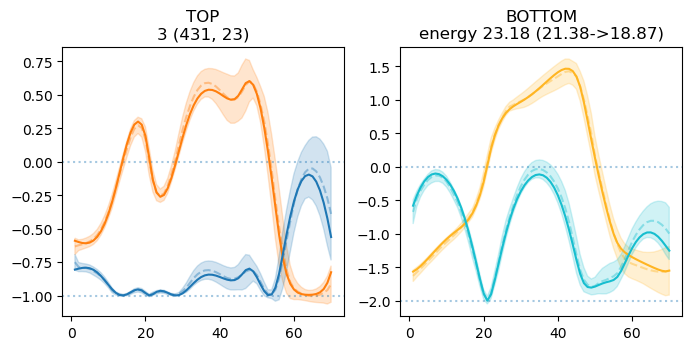

Damping α₁=0.10, α₂=0.05


In [679]:
# Plot!

_n += 1
fig, axs = subplots(1,2,figsize=(8,3.5))

cols2 = [plt.cm.tab10(1), plt.cm.tab10(0), yelloworng, plt.cm.tab10(9)];

[[axs[i].axhline(j, linestyle=":", alpha=0.4) for j in 0:-i:-i] for i in 1:2];
[credint(axs[ceil(Int, i/2)], yhat[:,i,_n], 2*exp.(logsigmas[:,i,_n]), col=cols2[i]) for i in 1:4]
[axs[ceil(Int, i/2)].plot(1:tT, yhat[:,i,_n], "--", color=cols2[i], alpha=0.4) for i in 1:4]
[axs[ceil(Int, i/2)].plot(1:tT, y[:,i,_n], color=cols2[i]) for i in 1:4]

axs[1].set_title(format("TOP\n{:d} ({:d}, {:d})", _n, seqixs[_n], ixs[_n]))
_E = [datagen.energy_dblpend(data_θ[tvt][seqixs[_n]][ixs[_n]+j,:]...) for j in [0,69]]
axs[2].set_title(format("BOTTOM\nenergy {:.2f} ({:.2f}->{:.2f})", data_meta[tvt][3][seqixs][_n], _E...))
printfmtln("Damping α₁={:.2f}, α₂={:.2f}", data_meta[tvt][4][1:2,seqixs[_n]]...)

### MT Bias GRU

<span style="color:red;font-size:30pt"><b>TODO: Not done at all yet.</b></span>

------------------

# Video Models

### Sequence-to-sequence

<span style="color:orange;font-size:20pt"><b>REDO: (CHECK) this is often quite bad.</b></span>

In [688]:
# Load model

video_rnn = seq2seq.create_model(128, 8, 4, 40, cnn=true)
modelutils.load!(video_rnn, "data/video_rnn_128_8_40.bson")
video_rnn_u = mapleaves(Tracker.data, video_rnn)

Seq2SeqModel(dim=4, CNN)

In [687]:
# Generate data

tvt = :train
tT, nbatch = 70, 20
yslices, fullseqs, seqixs, ixs = datagen.rand_timeseries(data_xy[tvt], data_meta[tvt], 
    tT, nbatch, entire_seq=true);
y = reduce(vcat, map(x->modelutils.unsqueeze(x, 1), yslices));

yslices = [cat([datagen.gen_pic_circ2_2chan_cood_tf(yslices[tt][1:2, s], yslices[tt][3:4, s])
            for s in 1:nbatch]..., dims=4) for tt in 1:tT]; # [32×32×2×nbatch]. The most expensive op here is `cat`...

In [788]:
# Simulate from model

yhats = video_rnn_u(yslices)
_t, _n = 0, 2

(0, 2)

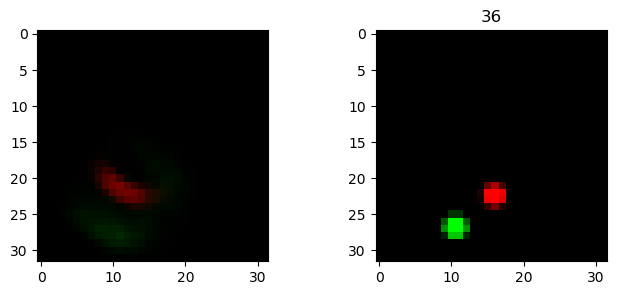

PyObject Text(0.5, 1.0, '36')

In [824]:
fig, axs = subplots(1,2,figsize=(8,3))
_t += 1

axs[1].imshow(modelutils.chan3cat(σ.(outs[1][_t][:,:,:,_n]))); title(_t)
axs[2].imshow(modelutils.chan3cat(outs[2][_t][:,:,:,_n])); title(_t)

### Multi-task (Full) GRU

<span style="color:orange;font-size:20pt"><b>REDO: For T_enc=10 (in progress).</b></span>

In [1694]:
include("src/multitask.jl")

Main.mtmodel

In [1695]:
video_mtgru = mtmodel.create_model(64, 6, 4, 40, 2, 2; encoder=:GRU, cnn=true, d_hidden=128)
modelutils.load!(video_mtgru, "data/mtgru_video_340.bson")
video_mtgru_u = mapleaves(Tracker.data, video_mtgru)  # remove AD

MTSeqModel_E3(Full-MT Recurrent Cell, d_x0=6, d_mt=2, d_chaos=2, CNN)

In [1544]:
# Generate data

tvt = :valid
tT, nbatch = 70, 20
yslices, fullseqs, seqixs, ixs = datagen.rand_timeseries(data_xy[tvt], data_meta[tvt], 
    tT, nbatch, entire_seq=true);
y = reduce(vcat, map(x->modelutils.unsqueeze(x, 1), yslices));

# The most expensive op below is `cat`...
yslices = [cat([datagen.gen_pic_circ2_2chan_cood_tf(yslices[tt][1:2, s], yslices[tt][3:4, s])
            for s in 1:nbatch]..., dims=4) for tt in 1:tT]; # [32×32×2×nbatch]. 
fullseqs = [cat([datagen.gen_pic_circ2_2chan_cood_tf(fullseqs[tt][1:2, s], fullseqs[tt][3:4, s])
            for s in 1:nbatch]..., dims=4) for tt in 1:tT]; # [32×32×2×nbatch]. 


# fullseqs = [gpu(cat([let D=data_xy[:train][s][1+tt,:]; gen_pic_circ2_2chan_cood_tf(D[1:2], D[3:4]); 
#                                     end for (s,i) in zip(seqixs, ixs)]..., dims=4))
#                             for tt in 0:2:2*tT-1]
#                 enc_yslices = [frame_enc(y) for y in y_slices]
#                 enc_fullseqs = [frame_enc(y) for y in fullseqs]    # wasteful, but avoids slow indexing

In [1541]:
nbatch = 100
yslices2 = y = Flux.batch([data_xy[:train][s][i .+ (0:tT-1), :] for (s,i) in zip(seqixs,ixs)])
    (time_slices) && (y = [y[tt,:,:] for tt in 1:tT])
y2 = reduce(vcat, map(x->modelutils.unsqueeze(x, 1), yslices2));

# The most expensive op below is `cat`...
yslices2 = [cat([datagen.gen_pic_circ2_2chan_cood_tf(yslices2[tt][1:2, s], yslices2[tt][3:4, s])
            for s in 1:nbatch]..., dims=4) for tt in 1:tT]; # [32×32×2×nbatch]. 
fullseqs2 = [cat([datagen.gen_pic_circ2_2chan_cood_tf(fullseqs2[tt][1:2, s], fullseqs2[tt][3:4, s])
            for s in 1:nbatch]..., dims=4) for tt in 1:tT]; # [32×32×2×nbatch]. 


In [1545]:
# Simulate from model

yhats_rnn = video_rnn_u(yslices)
yhats = video_mtgru_u(yslices, fullseqs; T_enc=70)
_t, _n = 0, 2

(0, 2)

In [1698]:
zall = map(1:50) do i
    fullseqs2 = Flux.batch([data_xy[:train][s][1:2:2*tT-1, :] for s in (20*(i-1)+1):20*i ])
    fullseqs2 = [cat([datagen.gen_pic_circ2_2chan_cood_tf(fullseqs2[tt, 1:2, s], fullseqs2[tt, 3:4, s])
                for s in 1:20]..., dims=4) for tt in 1:tT]; # [32×32×2×nbatch]. 
    mtmodel.posterior_samples(video_mtgru_u, [], fullseqs2; x0=1, c=1)[1][2]
end
zall = hcat(zall...);

10-element Array{Array{Float32,2},1}:
 [-0.0135305 -0.164874 … 0.114226 0.210125; 0.116841 0.0107435 … 0.581382 0.465066]
 [-0.274287 0.0986823 … 0.0980997 0.339934; 0.21714 -0.0663636 … 0.595192 0.359365]
 [-0.0639524 0.0663286 … 0.152402 0.38516; 0.0481728 -0.171318 … 0.547201 0.295854]
 [0.110218 -0.083961 … 0.428278 0.0245004; -0.133551 -0.143708 … 0.255343 0.663626]
 [0.113554 -0.162819 … 0.194388 0.339228; -0.126155 0.0342941 … 0.507044 0.287286] 
 [0.0594894 -0.183317 … 0.20676 0.0699338; 0.0562119 0.260788 … 0.45966 0.552153]  
 [0.113642 -0.104605 … 0.203447 0.53403; 0.0386595 0.166133 … 0.573233 0.318174]   
 [0.334582 0.18087 … 0.364199 0.239853; -0.0596374 -0.00903621 … 0.421785 0.480128]
 [0.409058 0.283376 … 0.44049 0.36432; -0.035076 0.0286138 … 0.403733 0.446757]    
 [0.354603 0.253763 … 0.660771 0.491022; 0.0349907 0.141332 … 0.229275 0.403319]   

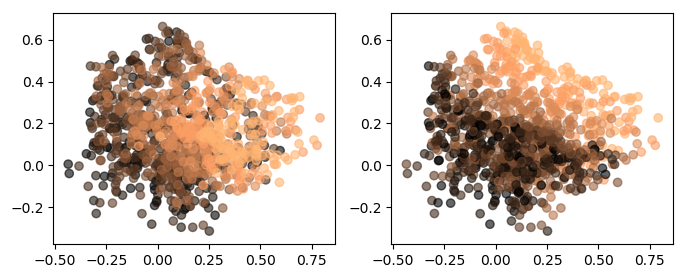

PyObject <matplotlib.collections.PathCollection object at 0x18536d710>

In [1714]:
fig, axs = subplots(1,2,figsize=(8,3))
axs[1].scatter(zall[1,:], zall[2,:], color=[plt.cm.copper((((i-1)÷10)÷10)/10) for i in 1:1000], alpha=0.6)
axs[2].scatter(zall[1,:], zall[2,:], color=[plt.cm.copper((((i-1)÷10) % 10)/10) for i in 1:1000], alpha=0.6)

In [1697]:
tmp =  mtmodel.posterior_samples(video_mtgru_u, [], fullseqs2; x0=1, c=1)[1][2]

2×100 Array{Float32,2}:
 0.000182149  -0.15956    -0.344268  …  0.219835  0.108921  0.204454
 0.130326     -0.0235702   0.307935     0.446142  0.578618  0.464565

In [1543]:
tmp[2]

2×100 Array{Float32,2}:
 -0.0175991  -0.00920357  -0.0323447  …  -0.0158974  -0.110273  -0.148675
 -0.203784    0.206921     0.254226       0.558824    0.230712   0.20869 

In [1380]:
_x0, _z, _c = mtmodel.posterior_samples(video_mtgru_u, yslices, fullseqs; T_steps=70, T_enc=70)[1];

In [1528]:
_zrnd = randn(Float32, 2, 20)*1
yhats = video_mtgru_u(_x0, _zrnd, _c; T_steps=70);

In [1617]:
_t, _n = 0, 7

(0, 7)

In [1688]:
fig, axs = subplots(1,3,figsize=(8,3))
_t += 1

axs[1].imshow(modelutils.chan3cat(σ.(yhats[_t][:,:,:,_n]))); axs[1].set_title("MT")
axs[2].imshow(modelutils.chan3cat(σ.(yhats_rnn[_t][:,:,:,_n]))); axs[2].set_title("RNN")
axs[3].imshow(modelutils.chan3cat(yslices[_t][:,:,:,_n])); title(format("Truth, t={:d}", _t))

BoundsError: BoundsError: attempt to access 70-element Array{Array{Float32,4},1} at index [71]

### Multi-task (Full) GRU

<span style="color:green;font-size:20pt"><b>Just finished.</b></span>

In [9]:
"data/mtbias_video_Tenc10_360.bson"

"data/mtbias_video_Tenc10_360.bson"